In [ ]:
 # IMPORTING MODULES
# import os
# import pandas as pd
# import glob
# import matplotlib.pyplot as plt
# from pandas.api.types import CategoricalDtype
# import plotly.express as px
# import chart_studio.plotly as py
# import plotly.figure_factory as ff
# import plotly.graph_objects as go


## Setting up path variables for easy and [generalized ?] access throughout the notebook

In [1]:
# SETTING PATH VARIABLES
# JUDICIAL_DATA_CSV_FOLDER_PATH = "/kaggle/input/precog-recruitment-task-csv/"

# ACTS_SECTIONS_CSV = os.path.join(
#                         JUDICIAL_DATA_CSV_FOLDER_PATH, 
#                         "acts_sections.csv"
#                     )

# CASES_CSV_FOLDER = os.path.join(
#                         JUDICIAL_DATA_CSV_FOLDER_PATH, 
#                         "cases/cases/"
#                     )

# JUDGES_CSV = os.path.join(
#                         JUDICIAL_DATA_CSV_FOLDER_PATH,
#                         "judges_clean/judges_clean.csv"
#                     )
# KEYS_CSV = os.path.join(
#                         JUDICIAL_DATA_CSV_FOLDER_PATH, 
#                         "keys.csv"
#                     )



# To test if the file is being read properly #

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

### Analyzing cases csv data 

- We will read the csv file first
- We will later change this to a for-loop so we can loop through every csv file




In [ ]:
# ()
#     df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))
#     df.head()
# joined_files = os.path.join(CASES_CSV_FOLDER, "cases_*.csv")
# joined_list = glob.glob(joined_files)
# df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)


In [ ]:
## Messing around

# df = df.sort_values(by = ['date_of_filing'], ascending = False)
# df.head()

### Plotting the number of pending cases 

#### How the data was preprocessed and analyzed?
- This was achieved by using the `date-of-filing` and `date-of-decision` columns
- A case is considered pending on a given date if the `date-of-filing` has passed but the `date-of-decision` has not been passed.
- The columns `date-of-filing` and `date-of-decision` were cleaned using the `Pandas.to_datetime()` method with the parameter `errors = coerce` to fill `NaT` in entries which were not in the correct `TimeStamp` format.
- The previous steps ensures that there are no faulty entries in either columns.
- A frequency map was created using `DataFrame[column].value_counts()`.
- Frequency of non occurent dates were filled with zeros using the `PandaSeries.reindex(range_of_dates, fill_value=0)` method.
- The graph is only shown for the given year, since, no cases filed after the given year are actually present in the `csv` file.

In [ ]:
# def pending_cases(df : pd.DataFrame, case_csv_year : int): 
#     df['date_of_filing'] = pd.to_datetime(
#         df['date_of_filing'], errors='coerce'
#     ).dt.date

#     df['date_of_decision'] = pd.to_datetime(
#         df['date_of_decision'], errors='coerce'
#     ).dt.date
    
#     range_of_dates = pd.date_range(
#                         f"{case_csv_year}-01-01", 
#                         f"{case_csv_year+1}-01-01"
#                     )

#     freq_filed_cases = df['date_of_filing'].value_counts()\
#                                            .asfreq('D', fill_value=0)

# #     freq_solved_cases = df['date_of_decision'].value_counts()\
# #                                               .asfreq('D', fill_value=0)

# #     freq_pending_cases = freq_filed_cases.subtract(freq_solved_cases)

#     df_pending_cases = pd.DataFrame({
#             'Date' : freq_filed_cases.index, 
#             'Num_filed_cases' : freq_filed_cases.values, 
#         })
    
#     df_pending_cases['weekday'] = df_pending_cases['Date'].dt.day_name()
    
#     return df_pending_cases

In [ ]:
# df_pending_cases = pending_cases(curr_df, 2014)
# case_csv_year = 2014

# pending_cases_plot_img(df_pending_cases, case_csv_year)

In [ ]:
# curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))

## Pending Cases plotter
- The number of cases received [TBX]

In [ ]:
def pending_cases_plot_img(df : pd.DataFrame, case_csv_year : int):
    fig = df.plot(
        x = 'Date', 
        y = ['Num_filed_cases'], 
        xlim = (f'{case_csv_year}-01-01', f'{case_csv_year + 1}-01-01'),
        ylim = (0,150000),
        figsize = (15,4)
    )
    return fig

## Iterating through all cases csv files
- Since, each `cases_[year].csv` is massive (~1-2 gigabytes) we will use a diff subplot for each csv file
- Each plot image is stored in a `plot_img_list`

In [ ]:
# plot_img_list = []
# df_list = []
# for year in range(2010, 2019):
#     curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"))
#     df_pending_cases = pending_cases(curr_df, year)
#     df_list.append(df_pending_cases)
#     plot_img_list.append(pending_cases_plot_img(df_pending_cases, year))

## Plotting number of cases filed on each day
- The `plot_img_list` obtained earlier can be iterated over and shown as subplots

In [ ]:
# curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv")
# df_pending_cases = pending_cases(curr_df, 2014)

# df.head()

In [ ]:
# curr_df_pending = pending_cases(curr_df)
# curr_df_pending['weekday'] = curr_df_pending['date'].dt.day_name()

# # curr_df_pending.head()


# freq_weekday = curr_df_pending.groupby(['weekday']).sum()
# freq_weekday.head()

# Insights on graphs obtained:
## Physical features of the graph
- The trend seems to violently oscillate.
- The amplitude of oscillation is increasing YoY.
- Weekends seem to be minimae getting only a fraction of cases on weekdays.
- Mondays and Wednesdays seem to be the maximae with Mondays receiving the highest number of cases on average.

## Implications of the physical features
- The density of cases filed are extremely high on weekdays, which suggests the direct
- The order of number of cases filed on peak days is of the order of 30000.
- The number of cases filed on peak days has steadily increased over the years.
- The period of 

# CLASSIFICATION PROBLEM IDEAS

- Given a day and Case ID, will it be decided on a given day.
- Given a day and Case ID, will it be decided on the next case day.
- 
- 

# OFFICIAL SUBMISSION AREA STARTS**

# Hello! I'm Ujjwal Shekhar:)
I will be analyzing the database of ~80 million Indian district court data across states from the Development Data Lab.

The csv file has been downloaded from [the dropbox link](https://www.dropbox.com/sh/hkcde3z2l1h9mq1/AAB2U1dYf6pR7qij1tQ5y11Fa/csv?dl=0&subfolder_nav_tracking=1).

The metadata can be found here:
- [Acts sections metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vTNxZtceqgzYlUogz-gJfMfqm-RygJZcqfZiFCQAsJYFG7BU1_ZT5aKTPrNODeDgRnoyZFBnjt2sghd/pubhtml)
- [All cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml)
- [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml)

The following project was done as a part of the recruitment task given by [Precog Research Lab](https://precog.iiit.ac.in/).

# Importing modules and libraries

In [23]:
# IMPORTING MODULES
import os
import numpy as np 
import pandas as pd 
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib 
from sklearn.preprocessing import LabelEncoder
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Context
![Shashi Tharoor gif](https://2.bp.blogspot.com/-6r5_T5XrC9Q/U6BLfMvIoLI/AAAAAAAABIc/kC5zGcduYCg/s1600/Waqt-ShashiKapoor.gif)
    
Ask any indian how they feel about the judicial system of their country, and they will come up with constant anecdotes of cases being stuck for years. The confidence that people have in our country's judicial system seems low, with as many as [4.7 crore cases](https://www.thehindu.com/news/national/indian-judiciary-pendency-data-courts-statistics-explain-judges-ramana-chief-justiceundertrials/article65378182.ece) pending.

We will look at a subset of cases (from 2010 to 2018) and look at judges' data and various other data provided to us. This will be a part of the **ANALYSIS** section of the recruitment task given.

Following this, we come up with a classification problem that will help with [TBX]. This will be a part of the **CLASSIFICATION** section.

```
NOTE: The markdown provided in this `.ipynb notebook` will also be clubbed together in the README.MD file in the Github Repository associated with the notebook.
```

# Setting path variables 
We will setup global path variables for easy access and uniformity throughout the notebook.

**_NOTE_**:
- Since each `cases_{year}.csv` file is very large, we will store the path to the `cases` folder instead.
- Similar reasons for the `/keys/` folder. 

In [6]:
JUDICIAL_DATA_CSV_FOLDER_PATH = "/kaggle/input/precog-recruitment-task-csv/"

ACTS_SECTIONS_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "acts_sections/acts_sections.csv"
                    )

CASES_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "cases/cases/"
                    )

JUDGES_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH,
                        "judges_clean/judges_clean.csv"
                    )
KEYS_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "keys/keys/"
                    )
print( f"""
    Judges CSV file path : {JUDGES_CSV}
    Cases CSV folder path : {CASES_CSV_FOLDER}
    Acts Sections CSV file path: {ACTS_SECTIONS_CSV}
    Keys CSV file path: {KEYS_CSV_FOLDER}
""")


    Judges CSV file path : /kaggle/input/precog-recruitment-task-csv/judges_clean/judges_clean.csv
    Cases CSV folder path : /kaggle/input/precog-recruitment-task-csv/cases/cases/
    Acts Sections CSV file path: /kaggle/input/precog-recruitment-task-csv/acts_sections/acts_sections.csv
    Keys CSV file path: /kaggle/input/precog-recruitment-task-csv/keys/keys/



# Pre-processing and analyzing data 
We will try analyzing the datasets we have. But before we analyze the data itself, we must get comfortable with the database and how it is structured and ensure that the data types are appropriate.
Following this we will look at many exploratory features of the data provided, this will be done for every file and at a later point, the preprocessing part will be standardised as a function for future use.


## Judges data
The [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml) file gives us the following information, 

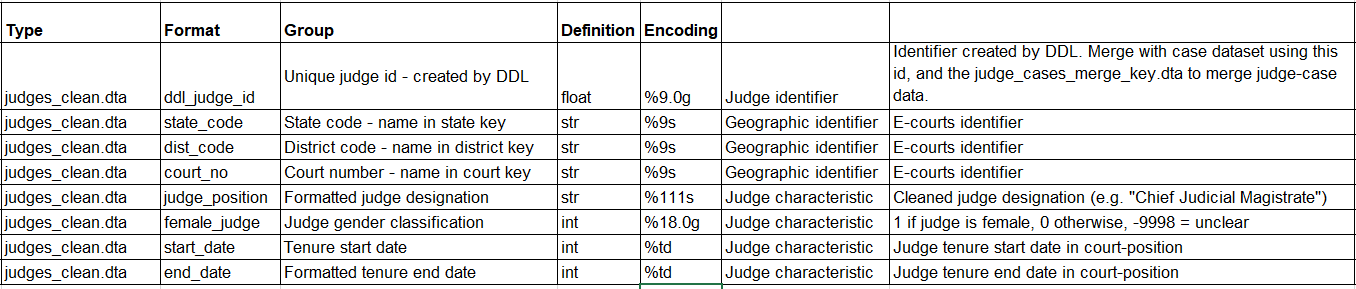

In [ ]:
df = pd.read_csv(JUDGES_CSV)
df.head()

Let's check whether or not the data type of each column is correct.

In [ ]:
df.dtypes

We can see that the `object` datatypes will actually be of the following types
- **judge_position** : `string`
- **female_judge** : [TBX]
- **start_date** and **end_date** : `Pandas.DateTime`

We will correct these dataypes first

In [ ]:
object_columns = df.select_dtypes(include = "object").columns
df[object_columns] = df[object_columns].astype("string")
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.date
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.date

df.dtypes

### Changing columns labels and replacing less readable values
On referring the DDL provided metadata (shown above), we realize that the following encoding was used in the `female_judge` column.

- 0 : male
- 1 : female
- -9998 : unclear

In [ ]:
df['female_judge'] = df['female_judge'].replace(
                ['0 nonfemale', '1 female', '-9998 unclear'],
                ['Male', 'Female', 'Unclear/Others']
            )
df = df.rename({'female_judge': 'gender'}, axis=1)
df['gender'] = df['gender'].astype("string")
df['gender'].head()

Since there is no numerical data to be analyzed, we will not use the `df.describe()` method here.

### Correlation matrix using Plotly.Express
We will use the correlation matrix to ensure that there are no columns with high correlation

**_NOTE:_** The corresponding correlation value has been shown as a colour, please refer to the color beside the correlation matrix image.

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

In [ ]:
le = LabelEncoder()
df['judge_position'] = le.fit_transform(df['judge_position']) 
df['gender'] = le.fit_transform(df['gender'])
df['start_date'] = le.fit_transform(df['start_date'])
df['end_date'] = le.fit_transform(df['end_date'])

px.imshow(df.corr(),title="Correlation Plot of Judges' database")

- We can see that `ddl_judge_id` and `state_code` are highly positively correlated, with a correlation value of ~$0.97$, this might be happening since 
- We can also see that `start_date` and `end_date` are also highly positively correlated, which also makes sense since `start_date` and`end_date` are constrained.
- `court_no` and `judge_position` are also quite correlated with ~$0.27$. A possible explanation might be that The Supreme Court will have a greater density of higher ranked judges. Although we might investigate this further.
- `end_date` also has a correlation ~$0.19$ with `dist_code` and `state_code`. 
<br>

## Making a preprocessing function for Judges' csv file.

In [7]:
def get_preprocessed_judges():
    df = pd.read_csv(JUDGES_CSV)
    object_columns = df.select_dtypes(include = "object").columns
    df[object_columns] = df[object_columns].astype("string")
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.date
    df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.date
    df['female_judge'] = df['female_judge'].replace(
                                            ['0 nonfemale', '1 female', '-9998 unclear'],
                                            ['Male', 'Female', 'Unclear/Others']
                                        )
    df = df.rename({'female_judge': 'gender'}, axis=1)
    df['gender'] = df['gender'].astype("string")
    df = df.dropna()
    
    df.dtypes
    return df

df = get_preprocessed_judges()


### Overall gender demographic across judges

In [ ]:
num_genders = df['gender'].value_counts()
num_genders.head()

fig = num_genders.plot.bar(x='lab', y='val', rot=0, title="Overall gender demographic across judges")

The ratio of male judges to female is approximately $2:1 :: Male : Female$

In [ ]:
df['court_no'].nunique()

In [ ]:
fig=px.histogram(df, 
                 x="judge_position",
                 color="gender",
                 hover_data=df.columns,
                 title="Judge demographic in different powers",
                 barmode="stack",
                 )\
      .update_xaxes(categoryorder="total descending")
fig.show()

Using the above histogram plot, we can see that majority of the judges are:

- Chief judicial magistrate
- Civil judge senior division
- Civil judge junior division
- Civil court
- Judicial magistrate court
- Additional Chief judicial magistrate
- City civil and sessions court
- Additional district and sessions court
- Family court
- Principal district and sessions court
- Principal civil judge; etc,.

We also observe that there are more male judges than female judges


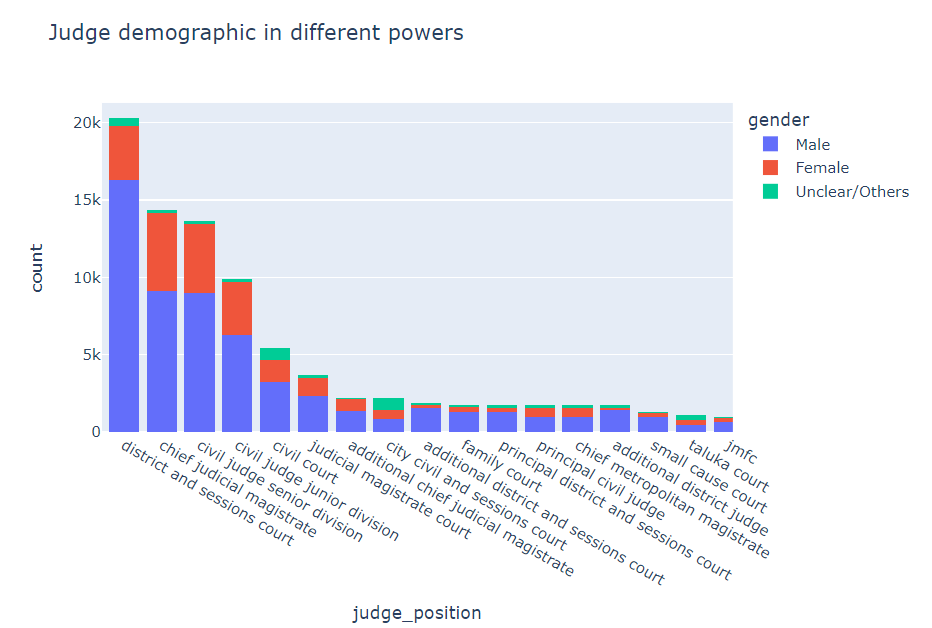

### Judges' gender demographic in different states

In [ ]:
fig=px.histogram(df, 
                 x="state_code",
                 color="gender",
                 hover_data=df.columns,
                 title="Judge gender demographic in different states",
                 barmode="stack",
                 )
fig.show()

We can see that the state with `state_code` = 1 has the highest total number of judges (~$22000$)

**_NOTE:_** The states have been anonimized using state codes.


We seem to have hit a roadblock, the judges csv seemingly gives no other insight.

### Trying to get hints for further analysis

Let's check if `end_date` has `NaN` values, so we can get the difference between them to get `total_days` they have worked for.

In [ ]:
df.isnull().sum()

Turns out that the `end_date` column DOES NOT have `Nan` values, if id did we would replace the `NaN` values to a date that can't logically be valid (like `01-01-2222`). Then we can simply get rid of all entries in the`total_days` column that can't be physically possible. 

### Creating the total days column

In [ ]:
df['total_days'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'D')
df

### Making a temporary dataframe
We make a temporary dataframe and select only the entries with`judge_position` entries occuring more than $2000$ times  

In [ ]:
sub_df = df.filter(['judge_position','total_days', 'gender', 'state_code', 'dist_code'], axis=1)\
        [df.groupby('judge_position').judge_position.transform('count')>2000].copy()

sub_df

### Finding distribution of `judge_position` along different `state_code`

In [ ]:
px.box(sub_df, x="judge_position", y="state_code", color="gender")

### Finding distribution of `judge_position` in different `dist_code`

In [ ]:
px.box(sub_df, x="judge_position", y="dist_code", color="gender")

### Violin plot to get insights on the data obtained

In [ ]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(
       x='total_days', 
       y='judge_position', 
       data=sub_df, 
       hue='gender', 
       ax=ax,
       title = "Judge_position in total days worked for",
    )

### Checking for skewness of features

In [ ]:
sub_df = df.filter(['total_days', 'gender'], axis=1)\
#         [df.groupby('judge_position').judge_position.transform('count')>2000].copy() 

plt.figure(figsize=(15,10))
for i,col in enumerate(sub_df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

## Acts Section data
The [Acts Sections metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vTNxZtceqgzYlUogz-gJfMfqm-RygJZcqfZiFCQAsJYFG7BU1_ZT5aKTPrNODeDgRnoyZFBnjt2sghd/pubhtml) file gives us the following information.

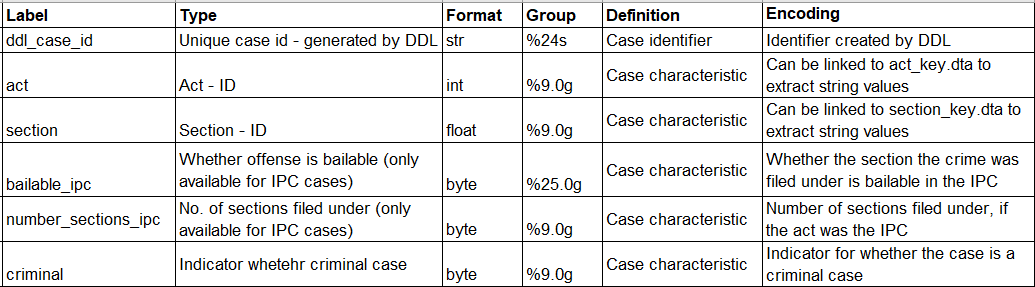

In [ ]:
df2 = pd.read_csv(ACTS_SECTIONS_CSV, dtype='unicode', usecols=['ddl_case_id', 'criminal'])
# df.head()

Lets check the data types

In [ ]:
df.dtypes

Since we had force`dtype=unicode` all columns now have `dtype` set as an `object`.

### Changing column labels and dtypes of columns

In [ ]:
df['ddl_case_id'] = df['ddl_case_id'].astype('string')
df['criminal'] = df['criminal'].astype('int64')

In [ ]:
df.dtypes

### Getting the number of criminals

`fig = px.histogram(df, x="criminal")` <br>
**WARNING** : Do not run the code, it might crash your laptop!!

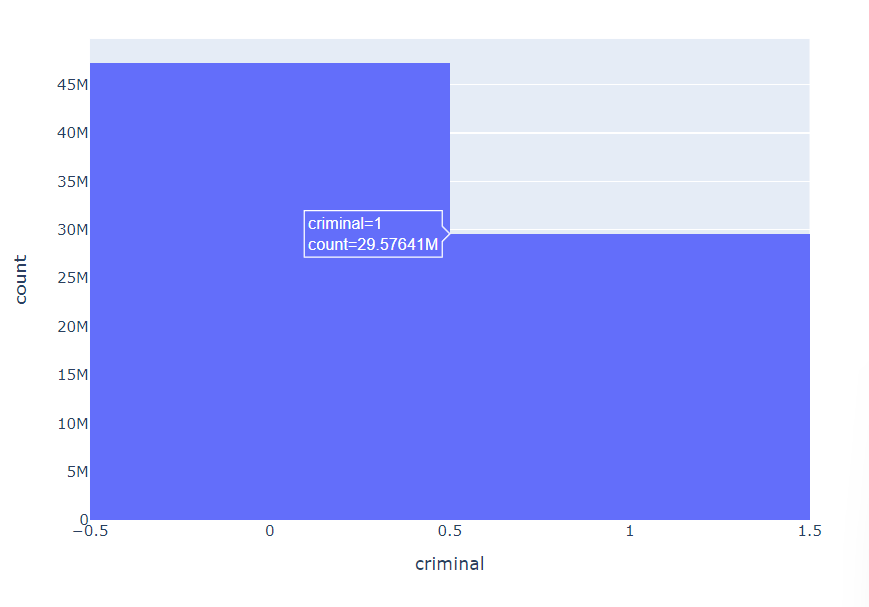

## Cases csv 
The [Cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml#) file gives us the following information,

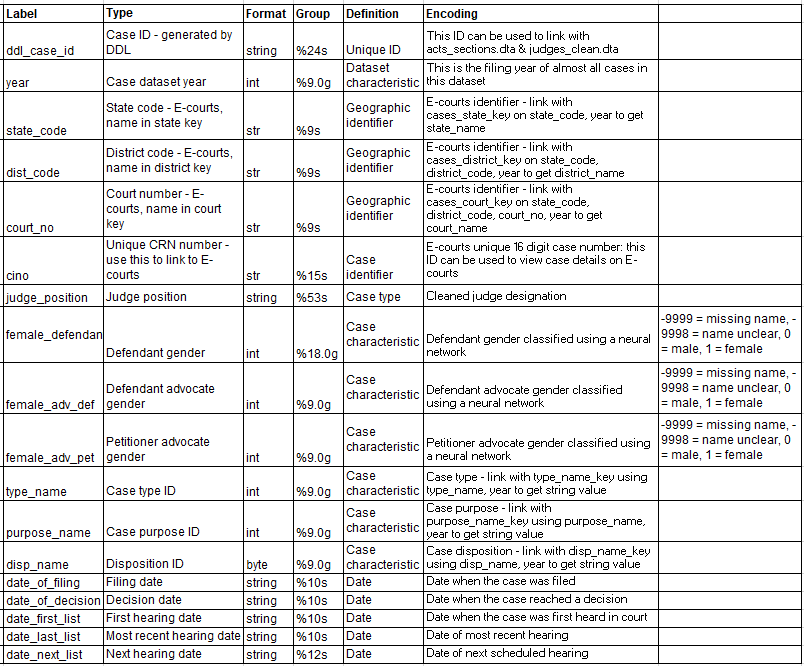

**NOTES:** 
- Since, each `case_{year}.csv` file is huge (~2GB each) we cannot handle more than one data frame at once.
- To be able to obtain insights for every year, we must make functions to handle a single data frame like before, except we can use a for-loop to call these functions for each `case_{year}.csv`.

Let's first make a list of years for easy reproducibility and readibility.

In [ ]:
year_list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### Exploring a sample csv
We will explore one case file and then make functions after every few steps so we can do the same for all `csv` files in the `CASES_CSV_FOLDER`.

**NOTE**: We will study the `cases_2014.csv` file, this csv has been selected since it is the median of `year_list` (No particular reason!)

In [ ]:
df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))
df.head()

Let's check for the dtypes, we can use the data obtained from the [Cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml#) file to then convert `object` dtypes to their corresponding valid dtypes.

In [ ]:
df.dtypes

In [ ]:
df.female_adv_def.unique()

There are a lot of columns that have to be converted into a non-object dtype!

In [ ]:
#################################################################
df['ddl_case_id'] = df['ddl_case_id'].astype("string")
df['state_code'] = df['state_code'].astype("string")
df['dist_code'] = df['dist_code'].astype("string")
df['court_no'] = df['court_no'].astype("string")
df['cino'] = df['cino'].astype("string")
df['judge_position'] = df['judge_position'].astype("string")
#################################################################


#################################################################
df['female_defendant'] = df['female_defendant'].replace(
    ['0 nonfemale', '1 female', '-9998 unclear', '-9999 missing name'],
    ['Male', 'Female', 'Unclear/Others', 'Missing']
)

df = df.rename({'female_defendant': 'judge_gender'}, axis=1)
df['judge_gender'] = df['judge_gender'].astype("string")
#################################################################


#################################################################
df['female_petitioner'] = df['female_petitioner'].replace(
    ['0 nonfemale', '1 female', '-9998 unclear', '-9999 missing name'],
    ['Male', 'Female', 'Unclear/Others', 'Missing']
)

df = df.rename({'female_petitioner': 'petitioner_gender'}, axis=1)
df['petitioner_gender'] = df['petitioner_gender'].astype("string")
#################################################################


#################################################################
df['female_adv_def'] = df['female_adv_def'].replace(
    ['0', '1', '-9998', '-9999'],
    ['Male', 'Female', 'Unclear/Others', 'Missing']
)

df = df.rename({'female_adv_def': 'adv_def_gender'}, axis=1)
df['adv_def_gender'] = df['adv_def_gender'].astype("string")
#################################################################


#################################################################
df['female_adv_pet'] = df['female_adv_pet'].replace(
    ['0', '1', '-9998', '-9999'],
    ['Male', 'Female', 'Unclear/Others', 'Missing']
)

df = df.rename({'female_adv_pet': 'adv_pet_gender'}, axis=1)
df['adv_pet_gender'] = df['adv_pet_gender'].astype("string")
#################################################################


#################################################################
# df['type_name'] = df['type_name'].astype("int64")
# df['purpose_name'] = df['purpose_name'].astype("int64")
#################################################################


#################################################################
df['date_of_filing'] = pd.to_datetime(
        df['date_of_filing'], errors='coerce'
    ).dt.date

df['date_of_decision'] = pd.to_datetime(
        df['date_of_decision'], errors='coerce'
    ).dt.date
#################################################################


#################################################################
df['date_first_list'] = pd.to_datetime(
        df['date_first_list'], errors='coerce'
    ).dt.date

df['date_last_list'] = pd.to_datetime(
        df['date_last_list'], errors='coerce'
    ).dt.date

df['date_next_list'] = pd.to_datetime(
        df['date_next_list'], errors='coerce'
    ).dt.date
#################################################################

In [ ]:
df.dtypes

We will drop all entries with any null value before studying the transforming strings by labelling them for correlation study

In [ ]:
df = df.dropna()

Now, that the data types have been fixed, and null values have been removed, lets plot the correlation matrix.

In [ ]:
le = LabelEncoder()
df['ddl_case_id'] = le.fit_transform(df['ddl_case_id'])
df['state_code'] = le.fit_transform(df['state_code']) 
df['dist_code'] = le.fit_transform(df['dist_code'])
df['court_no'] = le.fit_transform(df['court_no'])
df['cino'] = le.fit_transform(df['cino'])
df['judge_position'] = le.fit_transform(df['judge_position']) 
df['judge_gender'] = le.fit_transform(df['judge_gender'])
df['petitioner_gender'] = le.fit_transform(df['petitioner_gender'])
df['adv_def_gender'] = le.fit_transform(df['adv_def_gender'])
df['adv_pet_gender'] = le.fit_transform(df['adv_pet_gender'])
df['date_of_filing'] = le.fit_transform(df['date_of_filing']) 
df['date_of_decision'] = le.fit_transform(df['date_of_decision'])
df['date_first_list'] = le.fit_transform(df['date_first_list'])
df['date_last_list'] = le.fit_transform(df['date_last_list'])
df['date_next_list'] = le.fit_transform(df['date_next_list'])

df = df.drop(['year'], axis=1)

In [ ]:
px.imshow(df.corr(),title="Correlation Plot of Judges' database", text_auto=True)

In [ ]:
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_mat, ax=ax, annot=True)
fig.show()

- `date_next_list` and `date_last_list` are extremely correlated, we suspect that this is because the last time the `next` date was the `last` date filled.
- `date_first_list` is also positively correlated with `date_next_list` and `date_last_list`. This might be happening since 
- `date_first_list` and `date_of_filing` are also decently correlated, that might be because 
- A bunch of pairs of genders (e.g.: `adv_pet_gender` and `pertitioner_gender`) also have a correlation value of >$0.25$ 

Unfortunately the data that we have in the description table has numerical methods that are merely keys of string values, this is of no use to us.

We will plot the correlation matrix but alas, it won't be of much help either for the same reasons.

### Defining a function to preprocess cases_csv file

In [7]:
def preprocessing_case_csv(year=None, test_mode=False, to_unlabel=False):
    if not test_mode:
        df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"))
    else:
        df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"), nrows=10000)
    df['ddl_case_id'] = df['ddl_case_id'].astype("string")
    df['state_code'] = df['state_code'].astype("string")
    df['dist_code'] = df['dist_code'].astype("string")
    df['court_no'] = df['court_no'].astype("string")
    df['cino'] = df['cino'].astype("string")
    df['judge_position'] = df['judge_position'].astype("string")

    df['female_defendant'] = df['female_defendant'].replace(
        ['0 nonfemale', '0 male','1 female', '-9998 unclear', '-9999 missing name'],
        ['Male', 'Male', 'Female', 'Unclear/Others', 'Missing']
    )
    df = df.rename({'female_defendant': 'defendant_gender'}, axis=1)
    df['defendant_gender'] = df['defendant_gender'].astype("string")


    df['female_petitioner'] = df['female_petitioner'].replace(
        ['0 nonfemale', '0 male', '1 female', '-9998 unclear', '-9999 missing name'],
        ['Male', 'Male', 'Female', 'Unclear/Others', 'Missing']
    )
    df = df.rename({'female_petitioner': 'petitioner_gender'}, axis=1)
    df['petitioner_gender'] = df['petitioner_gender'].astype("string")

    df['female_adv_def'] = df['female_adv_def'].astype("string")
    df['female_adv_def'] = df['female_adv_def'].replace(
        ['0', '1', '-9998', '-9999'],
        ['Male', 'Female', 'Unclear/Others', 'Missing']
    )
    df = df.rename({'female_adv_def': 'adv_def_gender'}, axis=1)
    df['adv_def_gender'] = df['adv_def_gender'].astype("string")

    df['female_adv_pet'] = df['female_adv_pet'].astype("string")
    df['female_adv_pet'] = df['female_adv_pet'].replace(
        ['0', '1', '-9998', '-9999'],
        ['Male', 'Female', 'Unclear/Others', 'Missing']
    )

    df = df.rename({'female_adv_pet': 'adv_pet_gender'}, axis=1)
    df['adv_pet_gender'] = df['adv_pet_gender'].astype("string")


    df['date_of_filing'] = pd.to_datetime(
            df['date_of_filing'], errors='coerce'
        ).dt.date

    df['date_of_decision'] = pd.to_datetime(
            df['date_of_decision'], errors='coerce'
        ).dt.date


    df['date_first_list'] = pd.to_datetime(
            df['date_first_list'], errors='coerce'
        ).dt.date

    df['date_last_list'] = pd.to_datetime(
            df['date_last_list'], errors='coerce'
        ).dt.date

    df['date_next_list'] = pd.to_datetime(
            df['date_next_list'], errors='coerce'
        ).dt.date

    if to_unlabel:
        ### Joining states
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_state_key.csv"),
                                usecols = ['year','state_code', 'state_name'])
        df_merge['state_code'] = df_merge['state_code'].astype('string')
        df = df.merge(df_merge, on=['year', 'state_code'])
        
        ### Joining purpose names
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "purpose_name_key.csv"),
                              usecols=['year', 'purpose_name', 'purpose_name_s'])
        df = df.merge(df_merge, on=['year', 'purpose_name'])
        
        ### Joining disposition names
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "disp_name_key.csv"),
                              usecols=['year', 'disp_name', 'disp_name_s'])
        df = df.merge(df_merge, on=['year', 'disp_name'])
        
        ### Joining type names
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "type_name_key.csv"),
                              usecols=['year', 'type_name', 'type_name_s'])
        df = df.merge(df_merge, on=['year', 'type_name'])
        
        ### Joining districts
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_district_key.csv"),
                                usecols = ['state_code', 'dist_code', 'district_name'])
        df_merge['state_code'] = df_merge['state_code'].astype('string')
        df_merge['dist_code'] = df_merge['dist_code'].astype('string')
        df = df.merge(df_merge, on=['state_code', 'dist_code'])
        
        ### Joining court names
        df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_court_key.csv"),
                                usecols = ['year', 'state_code', 'dist_code', 'court_no', 'court_name'])
        df_merge['state_code'] = df_merge['state_code'].astype('string')
        df_merge['dist_code'] = df_merge['dist_code'].astype('string')
        df_merge['court_no'] = df_merge['court_no'].astype('string')
        df = df.merge(df_merge, on=['year', 'state_code', 'dist_code', 'court_no'])
        
        ### Removing extraneous columns
        df = df.drop(columns=['cino', 
                              'state_code', 'dist_code', 
                              'court_no', 'purpose_name', 
                              'type_name', 'disp_name'])
    return df

### Number of cases filed each day

We must look at how the number of filed cases changes over different time frames.

In [ ]:
plot_list = []
pending_cases_list = []
for year in range(2014,2016):
    df = preprocessing_case_csv(year)

    freq_filed_cases = df['date_of_filing']\
                            .value_counts()\
                            .asfreq('D', fill_value=0)

    df_pending_cases = pd.DataFrame({
            'Date' : freq_filed_cases.index, 
            'Num_filed_cases' : freq_filed_cases.values, 
        })

    df_pending_cases['weekday'] = df_pending_cases['Date']\
                                            .dt.day_name()
    
#     pending_cases_list.append(df_pending_cases)
    
    fig1 = px.line(df_pending_cases, x='Date', \
                   y="Num_filed_cases", range_y = (0,150000))
    fig2 = px.histogram(df_pending_cases, 
                 x="weekday",
                 title="Judge gender demographic in different states",
          )
    plot_list.append([fig1, fig2])

In [ ]:
# print(plot_list)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))
fig.add_trace(fig1)
fig.add_trace(fig2)
fig.add_trace(fig3)
fig.add_trace(fig4)

In [ ]:
fig = px.histogram(df, x="disp_name")

In [ ]:
fig.show()

We seem to have hit a wall here. But, we can always study the frequency and demographics.

**NOTE**: Going ahead it makes sense to study the frequency of occurence of certain values and trying to study the difference between the dates to get a time series analysis.

The reason that we are doing this is that the data in its current form will only give us `string` as data. The best thing to do will be to generate demographics and study it's skewness, we might find a good classification strategy in doing so (hopefully!!).


# Insight #1
## Analyzing criminal cases that get dismissed

A dismission is the disposition of a case when there isn't enough evidence for the case to continue, states with higher number of dismissed cases means that the judicial setup of that state is not competent enough and might suggest some form of corruption

### Merging appropriate dataframes 

We will start off by loading `cases_{year}.csv` here, for testing purposes let's try this with `case_2014.csv`. Then, we will merge the`criminal` column from `acts_sections.csv`.

In [10]:
df_acts_section = pd.read_csv(ACTS_SECTIONS_CSV, usecols=['ddl_case_id', 'act', 'section', 'criminal'])

In [6]:
df = preprocessing_case_csv(year=2014, to_unlabel=True)
df = df.merge(df_acts_section, on=['ddl_case_id'])

df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                      usecols=['act', 'act_s'])
df = df.merge(df_merge, on='act')

df.head(10)

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s
0,01-01-01-201908000022014,2014,chief judicial magistrate,Unclear/Others,Male,Missing,Unclear/Others,2014-01-03,2014-10-28,2014-01-16,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,841964.0,1,The Indian Penal Code
1,01-01-01-201908000072014,2014,chief judicial magistrate,Male,Male,Missing,Male,2014-01-04,2014-01-04,2014-01-04,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1064270.0,1,The Indian Penal Code
2,01-01-01-201908000102014,2014,chief judicial magistrate,Male,Female,Missing,Male,2014-01-07,2014-01-07,2014-01-07,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1064270.0,1,The Indian Penal Code
3,01-01-01-201908000302014,2014,chief judicial magistrate,Female,Male,Missing,Male,2014-01-21,2014-01-21,2014-01-21,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1064270.0,1,The Indian Penal Code
4,01-01-01-201908000422014,2014,chief judicial magistrate,Male,Female,Missing,Unclear/Others,2014-02-05,2014-02-05,2014-02-05,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,841964.0,1,The Indian Penal Code
5,01-01-01-201908000462014,2014,chief judicial magistrate,Female,Male,Missing,Male,2014-02-06,2014-02-06,2014-02-06,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1044684.0,1,The Indian Penal Code
6,01-01-01-201908000532014,2014,chief judicial magistrate,Male,Female,Missing,Male,2014-02-20,2014-08-18,2014-02-20,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1111430.0,1,The Indian Penal Code
7,01-01-01-201908000572014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Male,2014-02-26,2015-11-21,2014-02-26,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1064270.0,1,The Indian Penal Code
8,01-01-01-201908000732014,2014,chief judicial magistrate,Male,Male,Missing,Unclear/Others,2014-03-10,2014-08-28,2014-03-10,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1176149.0,1,The Indian Penal Code
9,01-01-01-201908000762014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Female,2014-03-12,2015-08-13,2014-03-12,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353.0,1140139.0,1,The Indian Penal Code


In [7]:
df = df.dropna()

### Checking how quickly each state responds to a criminal case being filed
We can check this by finding the number of days between `date_first_list` and `date_of_filing`.

In [8]:
df['date_first_list'] = pd.to_datetime(
    df['date_first_list'], errors='coerce'
).dt.date
df["quickness_of_action"] = ((df.date_first_list - df.date_of_filing)/np.timedelta64(1, 'D')).astype(int)

We will remove all non-criminal cases.

In [9]:
df.criminal = df.criminal.astype('bool')
df.criminal.value_counts()

False    3780262
True     1465783
Name: criminal, dtype: int64

In [10]:
df = df[(df.criminal == True)]

Let's also drop the `ddl_case_id` and `cino` columns since they are unique identifiers mostly useful for connecting tables.

In [11]:
df = df.drop(columns=['ddl_case_id', 'act'])

Let's plot the correlation matrix before replacing labels with their string values.

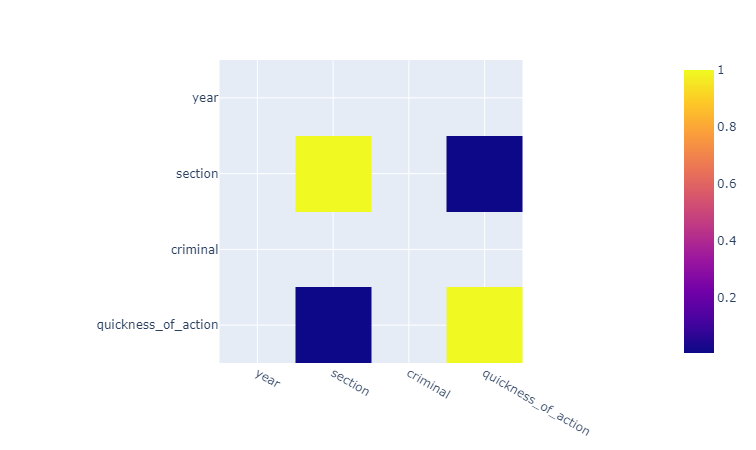

In [12]:
px.imshow(df.corr())

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465783 entries, 0 to 2726164
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   year                 1465783 non-null  int64  
 1   judge_position       1465783 non-null  string 
 2   defendant_gender     1465783 non-null  string 
 3   petitioner_gender    1465783 non-null  string 
 4   adv_def_gender       1465783 non-null  string 
 5   adv_pet_gender       1465783 non-null  string 
 6   date_of_filing       1465783 non-null  object 
 7   date_of_decision     1465783 non-null  object 
 8   date_first_list      1465783 non-null  object 
 9   date_last_list       1465783 non-null  object 
 10  date_next_list       1465783 non-null  object 
 11  state_name           1465783 non-null  object 
 12  purpose_name_s       1465783 non-null  object 
 13  disp_name_s          1465783 non-null  object 
 14  type_name_s          1465783 non-null  object 
 15

Finally, let's use the `keys` folder to switch from labels to their values

In [14]:
avg_quickness_states = df.groupby(['state_name'])['quickness_of_action'].mean()
avg_quickness_states.sort_values(ascending=False)
avg_quickness_states.head(10)

state_name
Andhra Pradesh    123.603627
Assam             172.081858
Bihar             143.590164
Chandigarh         36.601718
Chhattisgarh      107.507688
DNH at Silvasa     48.015695
Delhi              48.568609
Diu and Daman      39.050000
Goa                77.767773
Gujarat            68.630212
Name: quickness_of_action, dtype: float64

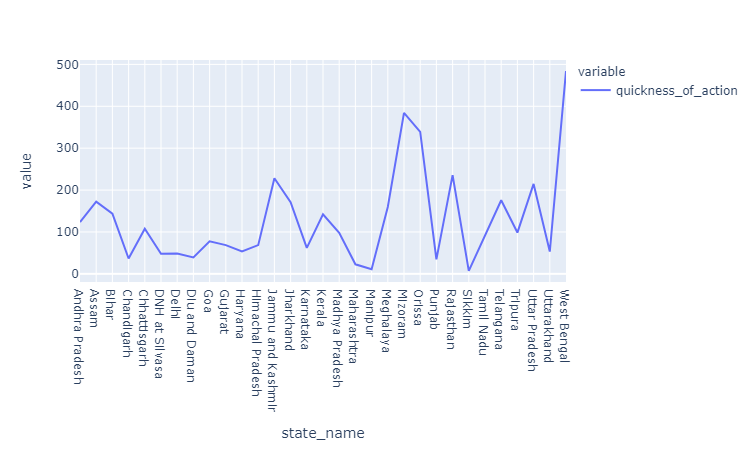

In [15]:
px.line(avg_quickness_states)

### Getting statewise time taken for a case to get its first hearing date from the day of filing.

In [16]:
time_taken_states = avg_quickness_states.to_frame()
time_taken_states = time_taken_states.reset_index()
time_taken_states.head(10)

,state_name,quickness_of_action
0,Andhra Pradesh,123.603627
1,Assam,172.081858
2,Bihar,143.590164
3,Chandigarh,36.601718
4,Chhattisgarh,107.507688
5,DNH at Silvasa,48.015695
6,Delhi,48.568609
7,Diu and Daman,39.050000
8,Goa,77.767773
9,Gujarat,68.630212


In [17]:
time_taken_states = time_taken_states.replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )
val = time_taken_states[time_taken_states['state_name']=='Jammu & Kashmir'].values[0][1]
time_taken_states = time_taken_states.append({
    'state_name' : 'Ladakh',
    'quickness_of_action' : val
}, ignore_index=True)

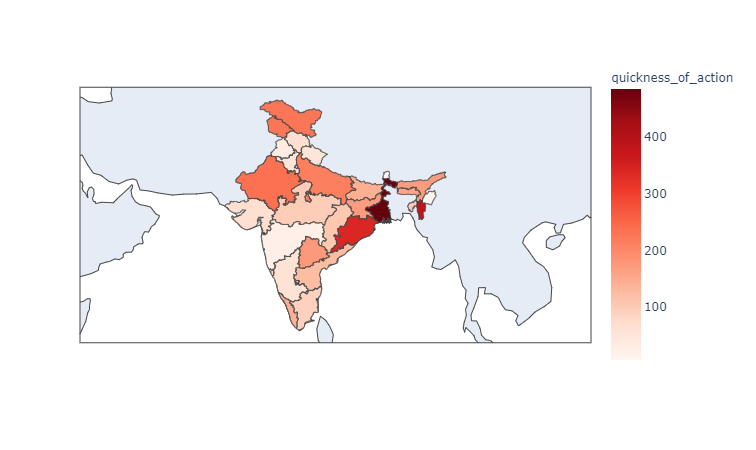

In [18]:
px.choropleth(
    time_taken_states,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='quickness_of_action',
    color_continuous_scale='Reds',
    fitbounds="locations"
)

In [19]:
avg_quickness_district = df.groupby(['district_name'])['quickness_of_action'].mean()
avg_quickness_district = avg_quickness_district.to_frame()
avg_quickness_district = avg_quickness_district.reset_index()

# avg_quickness_district = avg_quickness_district[avg_quickness_district.quickness_of_action > 1000]
avg_quickness_district.head(10)

,district_name,quickness_of_action
0,Adilabad,178.696460
1,Agra,301.887043
2,Ahmedabad,76.755495
3,Ahmednagar,4.329880
4,Aizawl,384.409091
5,Ajmer,203.552941
6,Akola,11.434639
7,Alappuzha,119.165168
8,Aligarh,913.488789
9,Alirajpur,308.789474


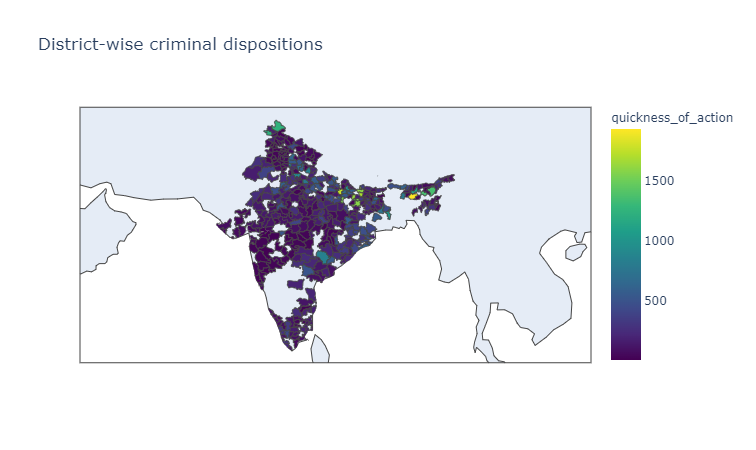

In [20]:
px.choropleth(
    avg_quickness_district,
    geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
    featureidkey='properties.NAME_2',
    locations='district_name',
    color='quickness_of_action',
    fitbounds="locations",
    color_continuous_scale='Viridis',
    title='District-wise criminal dispositions',
)

### Making a frequency table of each disposition

In [21]:
df.head()

,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,date_last_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,section,criminal,act_s,quickness_of_action
0,2014,chief judicial magistrate,Unclear/Others,Male,Missing,Unclear/Others,2014-01-03,2014-10-28,2014-01-16,2014-09-30,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,841964.0,True,The Indian Penal Code,13
1,2014,chief judicial magistrate,Male,Male,Missing,Male,2014-01-04,2014-01-04,2014-01-04,2014-01-04,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,1064270.0,True,The Indian Penal Code,0
2,2014,chief judicial magistrate,Male,Female,Missing,Male,2014-01-07,2014-01-07,2014-01-07,2014-01-07,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,1064270.0,True,The Indian Penal Code,0
3,2014,chief judicial magistrate,Female,Male,Missing,Male,2014-01-21,2014-01-21,2014-01-21,2014-01-21,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,1064270.0,True,The Indian Penal Code,0
4,2014,chief judicial magistrate,Male,Female,Missing,Unclear/Others,2014-02-05,2014-02-05,2014-02-05,2014-02-05,...,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,841964.0,True,The Indian Penal Code,0


In [22]:
disp_freq_state_wise = (df.groupby(['year', 'disp_name_s'])['state_name'].value_counts()).to_frame()
disp_freq_state_wise.columns = ['count']
disp_freq_state_wise = disp_freq_state_wise.reset_index()
disp_freq_state_wise['state_name'] = disp_freq_state_wise['state_name'].replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )

val = disp_freq_state_wise[disp_freq_state_wise['state_name']=='Jammu & Kashmir'].values
for entry in val:
    disp_freq_state_wise = disp_freq_state_wise.append({
        'state_name' : 'Ladakh',
        'disp_name_s' : entry[1],
        'year' : entry[0],
        'count': entry[3]
    }, ignore_index=True)

disp_freq_state_wise.head(10)

,year,disp_name_s,state_name,count
0,2014,258 crpc,Maharashtra,2851
1,2014,258 crpc,Kerala,311
2,2014,258 crpc,Chhattisgarh,38
3,2014,258 crpc,Karnataka,20
4,2014,258 crpc,Uttarakhand,10
5,2014,258 crpc,Uttar Pradesh,8
6,2014,258 crpc,Dadra and Nagar Haveli and Daman and Diu,4
7,2014,258 crpc,Telangana,3
8,2014,258 crpc,Haryana,2
9,2014,258 crpc,Assam,1


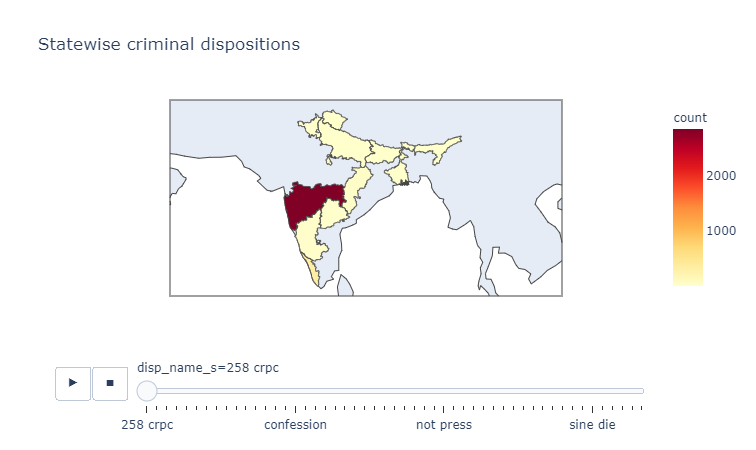

In [23]:
px.choropleth(
    disp_freq_state_wise,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='count',
    animation_frame='disp_name_s',
    fitbounds="locations",
    color_continuous_scale='YlOrRd',
    title='Statewise criminal dispositions'
)

### Analyzing district-wise to get clusters of dispositions across the map

In [24]:
disp_freq_district_wise = (df.groupby(['year', 'disp_name_s'])['district_name'].value_counts()).to_frame()
disp_freq_district_wise.columns = ['count']
disp_freq_district_wise = disp_freq_district_wise.reset_index()

disp_freq_district_wise.head(10)

,year,disp_name_s,district_name,count
0,2014,258 crpc,Mumbai CMM Courts,270
1,2014,258 crpc,Pune,235
2,2014,258 crpc,Nagpur,188
3,2014,258 crpc,Idukki,186
4,2014,258 crpc,Amravati,167
5,2014,258 crpc,Nashik,162
6,2014,258 crpc,Satara,153
7,2014,258 crpc,Dhule,145
8,2014,258 crpc,Parbhani,121
9,2014,258 crpc,Osmanabad,118


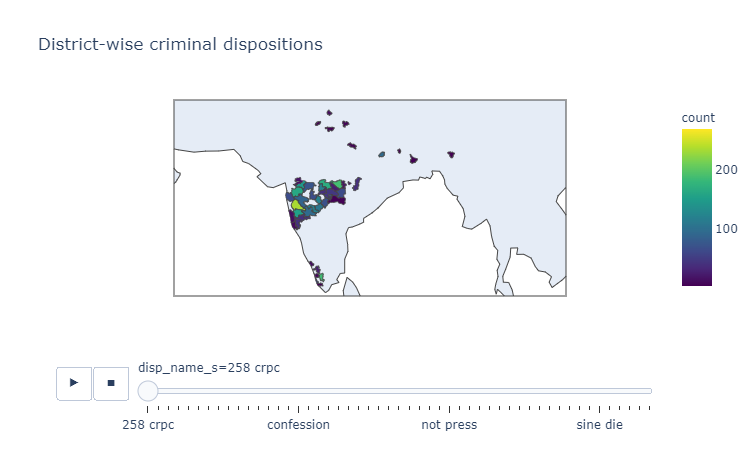

In [25]:
px.choropleth(
    disp_freq_district_wise,
    geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
    featureidkey='properties.NAME_2',
    locations='district_name',
    color='count',
    animation_frame='disp_name_s',
    fitbounds="locations",
    color_continuous_scale='Viridis',
    title='District-wise criminal dispositions',
)

### Standardizing everything as a function, and putting yearwise plots/series in lists that we will later access

In [8]:
quickness_line_plots = []
time_taken_states_chloropleths = []
avg_quickness_states_list = []

avg_quickness_district_list = []
time_taken_districts_chloropleths = []

state_wise_disp_list = []
state_wise_disp_chloropleths = []

district_wise_disp_list = []
district_wise_disp_chloropleths = []

def insight_1(df):
    ### Rate of response study of criminal cases
    avg_quickness_states = df.groupby(['state_name'])['quickness_of_action'].mean()
    avg_quickness_states.sort_values(ascending=False)
    
    ### Save the series obtained
    avg_quickness_states_list.append(avg_quickness_states)

    ### Save the line plot
    fig = px.line(avg_quickness_states)
    quickness_line_plots.append(fig)
    
    ### Plot chloropleth
    time_taken_states = avg_quickness_states.to_frame()
    time_taken_states = time_taken_states.reset_index()
    
    time_taken_states = time_taken_states.replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )
    val = time_taken_states[time_taken_states['state_name']=='Jammu & Kashmir'].values[0][1]
    time_taken_states = time_taken_states.append({
        'state_name' : 'Ladakh',
        'quickness_of_action' : val
    }, ignore_index=True)
    time_taken_states = time_taken_states.replace(
                ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
                ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
            )
    val = time_taken_states[time_taken_states['state_name']=='Jammu & Kashmir'].values[0][1]
    time_taken_states = time_taken_states.append({
        'state_name' : 'Ladakh',
        'quickness_of_action' : val
    }, ignore_index=True)
    
    fig = px.choropleth(
        time_taken_states,
        geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        featureidkey='properties.ST_NM',
        locations='state_name',
        color='quickness_of_action',
        color_continuous_scale='Reds',
        fitbounds="locations"
    )
    ### Save chloropleth for the time taken for each state
    time_taken_states_chloropleths.append(fig)
    
    ### District-wise quickness of action
    avg_quickness_district = df.groupby(['district_name'])['quickness_of_action'].mean()
    avg_quickness_district = avg_quickness_district.to_frame()
    avg_quickness_district = avg_quickness_district.reset_index()
    
    avg_quickness_district_list.append(avg_quickness_district)

    fig = px.choropleth(
        avg_quickness_district,
        geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
        featureidkey='properties.NAME_2',
        locations='district_name',
        color='quickness_of_action',
        fitbounds="locations",
        color_continuous_scale='Viridis',
        title='District-wise criminal dispositions',
    )
    
    time_taken_districts_chloropleths.append(fig)
    
    ### Statewise disposition choloropleth heat map
    disp_freq_state_wise = (df.groupby(['year', 'disp_name_s'])['state_name'].value_counts()).to_frame()
    disp_freq_state_wise.columns = ['count']
    disp_freq_state_wise = disp_freq_state_wise.reset_index()
    disp_freq_state_wise['state_name'] = disp_freq_state_wise['state_name'].replace(
                ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
                ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
            )

    val = disp_freq_state_wise[disp_freq_state_wise['state_name']=='Jammu & Kashmir'].values
    for entry in val:
        disp_freq_state_wise = disp_freq_state_wise.append({
            'state_name' : 'Ladakh',
            'disp_name_s' : entry[1],
            'year' : entry[0],
            'count': entry[3]
        }, ignore_index=True)

    state_wise_disp_list.append(disp_freq_state_wise)
    
    ### Saving the chloropleth obtained
    fig = px.choropleth(
        disp_freq_state_wise,
        geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        featureidkey='properties.ST_NM',
        locations='state_name',
        color='count',
        animation_frame='disp_name_s',
        fitbounds="locations",
        color_continuous_scale='YlOrRd',
        title='Statewise criminal dispositions'
    )
    
    state_wise_disp_chloropleths.append(fig)
    
    ### District-wise frequency of dispositions
    disp_freq_district_wise = (df.groupby(['year', 'disp_name_s'])['district_name'].value_counts()).to_frame()
    disp_freq_district_wise.columns = ['count']
    disp_freq_district_wise = disp_freq_district_wise.reset_index()
    
    district_wise_disp_list.append(disp_freq_district_wise)
    
    ### Saving the chloropleths obtained
    fig = px.choropleth(
        disp_freq_district_wise,
        geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
        featureidkey='properties.NAME_2',
        locations='district_name',
        color='count',
        animation_frame='disp_name_s',
        fitbounds="locations",
        color_continuous_scale='Viridis',
        title='District-wise criminal dispositions',
    )
    
    district_wise_disp_chloropleths.append(fig)

In [14]:
for year in range(2010,2012):
    df = preprocessing_case_csv(year=year, to_unlabel=True)
    df = df.merge(df_acts_section, on=['ddl_case_id'])

    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                          usecols=['act', 'act_s'])
    df = df.merge(df_merge, on='act')
    
    df = df.dropna()
    df['date_first_list'] = pd.to_datetime(
        df['date_first_list'], errors='coerce'
    ).dt.date
    df["quickness_of_action"] = ((df.date_first_list - df.date_of_filing)/np.timedelta64(1, 'D')).astype(int)

    df.criminal = df.criminal.astype('bool')
    
    df = df[(df.criminal == True)]
    df = df.drop(columns=['ddl_case_id', 'act'])
    
    insight_1(df)

In [44]:
def plot_list_figures(plots_list=None, test_mode=False, title_text=None):
    # Initialize a 2x1 grid of subplots
#     fig = sp.make_subplots(rows=2, cols=1)

    # Add each fig from the list as a subplot
    for i, f in enumerate(quickness_line_plots):
        f.show()

In [45]:
quickness_line_plots = [quickness_line_plots[0], quickness_line_plots[1]]

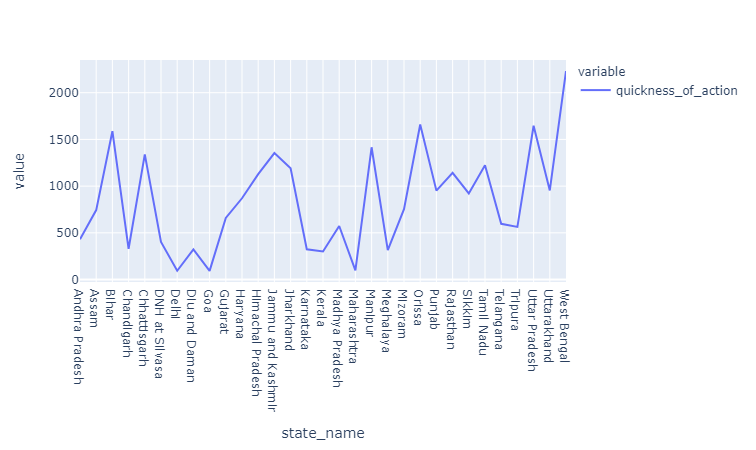

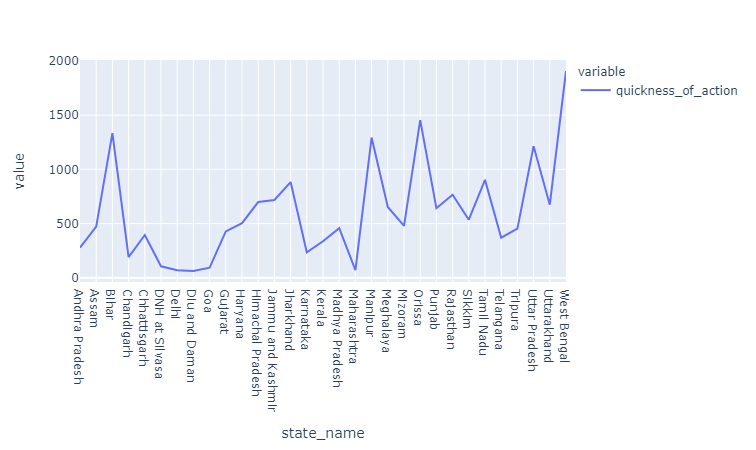

In [46]:
plot_list_figures(quickness_line_plots, True, "State_wise mean time taken to hear a criminal case after it's filing")

In [49]:
colors_list = [
    "#808000",
    "#911eb4",
    "#9A6324",
    "#000000",
    "#000075",
    "#fabed4",
    "#aaffc3",
    "#dcbeff",
]

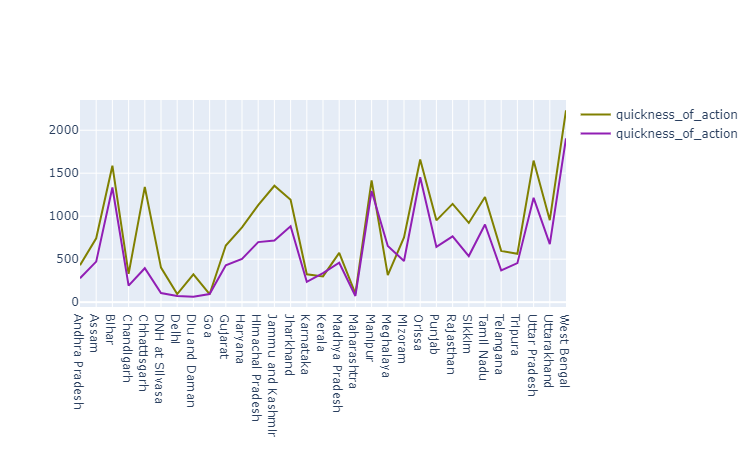

In [55]:
for i in range(int(len(quickness_line_plots))):
    quickness_line_plots[i]['data'][0]['line']['color']=colors_list[i]
    
data = quickness_line_plots[0].data
for i in range(int(len(quickness_line_plots))):
    if i != 0:
        data += quickness_line_plots[i].data
# fig_net = go.Figure(data=quickness_line_plots[0].data+quickness_line_plots[1].data)
fig_net = go.Figure(data=data)
fig_net.show()

# Insight #2
## Analyzing marriage related cases, religion-marriage case count, child marriage case count


In [5]:
df = preprocessing_case_csv(year=2014, to_unlabel=True)

In [7]:
df = df.merge(df_acts_section, on=['ddl_case_id'])
df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                      usecols=['act', 'act_s'])
df = df.merge(df_merge, on='act')

In [8]:
df = df.dropna()

In [9]:
pattern = '.*(Marriage|marriage|MARRIAGE|Divorce|DIVORCE).*'
df2 = df[df.act_s.str.match(pattern)]
df2.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s
3155635,01-01-04-202717000132014,2014,civil judge junior division,Female,Male,Missing,Male,2014-04-18,2015-03-10,2014-06-13,...,Maharashtra,argument,ex-parte,r.c.s.,Nandurbar,Civil Court J.D. and J.M.F.C.Taloda,16320.0,3706.0,0,Special Marriage Act
3155636,01-01-08-202716000122014,2014,civil judge junior division,Female,Male,Missing,Male,2014-02-26,2017-01-24,2014-03-27,...,Maharashtra,steps,reject,r.c.s.,Nandurbar,"Civil Court, J.D. and J.M.F.C., Nawapur.",16320.0,868951.0,0,Special Marriage Act
3155637,01-01-03-207406000022014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-01,2015-07-08,2014-11-01,...,Maharashtra,hearing,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,46338.0,0,Special Marriage Act
3155638,01-01-03-207406000012014,2014,district and sessions court,Female,Male,Missing,Male,2014-10-10,2018-10-19,2014-11-03,...,Maharashtra,stayed by district court,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,1837075.0,0,Special Marriage Act
3155639,01-02-01-207400000042014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-15,2015-06-08,2014-11-15,...,Maharashtra,order,judgement,spl. marriage petn.,Dhule,"DISTRICT AND SESSIONS COURT, DHULE",16320.0,678480.0,0,Special Marriage Act


In [10]:
df3 = df2[df2.defendant_gender == df2.petitioner_gender]
df3.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s
3155648,01-03-02-207401000242014,2014,district and sessions court,Male,Male,Missing,Male,2014-11-07,2015-06-30,2014-11-07,...,Maharashtra,hearing,judgement,spl. marriage petn.,Jalgaon,DISTRICT AND SESSIONS COURT JALGAON,16320.0,678419.0,0,Special Marriage Act
3155686,01-04-01-207401000022014,2014,district and sessions court,Male,Male,Missing,Male,2014-01-16,2017-08-22,2014-01-16,...,Maharashtra,stayed by honble high court,transferred,spl. marriage petn.,Buldhana,"DISTRICT COURT, BULDANA",16320.0,636811.0,0,Special Marriage Act
3155693,01-05-01-207401000032014,2014,principal district and sessions court,Male,Male,Missing,Male,2014-08-06,2016-11-28,2014-08-08,...,Maharashtra,order,dismissed,spl. marriage petn.,Akola,"Principal District and Sessions Judge, Akola",16320.0,604936.0,0,Special Marriage Act
3155695,01-05-01-207401000012014,2014,principal district and sessions court,Male,Male,Missing,Unclear/Others,2014-02-27,2014-07-28,2014-02-27,...,Maharashtra,notice_unready,ex-parte,spl. marriage petn.,Akola,"Principal District and Sessions Judge, Akola",16320.0,635866.0,0,Special Marriage Act
3155702,01-07-06-207405000032014,2014,district and sessions court,Male,Male,Missing,Male,2014-09-11,2016-03-28,2014-09-11,...,Maharashtra,judgement,judgement,spl. marriage petn.,Amravati,COURT OF DISTRICT JUDGE-1 ACHALPUR,16320.0,679912.0,0,Special Marriage Act


In [11]:
df3.act_s.unique()

array(['Special Marriage Act', 'Dissolution of Muslim Marriages Act',
       'Hindu Marriage Act', 'CHILD MARRIAGE RESTRAINT ACT',
       'Muslim Marriage Act',
       'Muslim Women (Protection Of Right On Divorce) Act,1986',
       'Muslim Women (Protection Of Right On Divorce)Act ,1986',
       'Christian Marriage Act, 1872', 'Indian Divorce Act',
       'Muslim Divorce Act', 'Child Marriage Act', 'HINDU MARRIAGE ACT',
       'SPECIAL  MARRIAGE ACT', 'DIVORCE ACT', 'MUSLIM DIVORCE ACT',
       'SPECIAL MARRIAGE ACT', 'SPECIAL MARRIAGE ACT1954',
       'THE HINDU MARRIAGE ACT 1955', 'MUSLIM DIVORCE ACT1984',
       'THE DIVORCE ACT1869', 'Muslim Divorce Act 1939',
       'THE HINDU MARRIAGE ACT, 1955', 'THE SPECIAL MARRIAGE ACT, 1954',
       'Marriages Validation Act',
       'Hindu Marriages (Validation of Proceedings) Act', 'Divorce Act',
       'Muslim Women (Protection of Rights on Divorce) Act',
       'Anand Marriage Act', 'Prohibition of Child Marriage Act',
       'Dissolutio

### Making clusters based on religion
We will try to analyze marriage related cases in different religions

To do this, we will add a column `act_religion`
The column will use a regex pattern to detect the religion.

In [12]:
def get_religion(act_s : str):
    pattern_hindu = '.*(Hindu|HINDU|hindu).*'
    pattern_muslim = '.*(muslim|MUSLIM|Muslim).*'
    pattern_christian = '.*(christian|CHRISTIAN|Christian).*'
    pattern_parsi = '.*(parsi|PARSI|Parsi).*'
    
    if bool(re.search(pattern_hindu, act_s)):
        return "Hindu"
    elif bool(re.search(pattern_muslim, act_s)):
        return "Muslim"
    elif bool(re.search(pattern_christian, act_s)):
        return "Christian"
    elif bool(re.search(pattern_parsi, act_s)):
        return "Parsi"
    else:
        return "Unclear"

df2['act_religion'] = df2.apply(lambda row : get_religion(row['act_s']), axis=1)

In [13]:
df2.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s,act_religion
3155635,01-01-04-202717000132014,2014,civil judge junior division,Female,Male,Missing,Male,2014-04-18,2015-03-10,2014-06-13,...,argument,ex-parte,r.c.s.,Nandurbar,Civil Court J.D. and J.M.F.C.Taloda,16320.0,3706.0,0,Special Marriage Act,Unclear
3155636,01-01-08-202716000122014,2014,civil judge junior division,Female,Male,Missing,Male,2014-02-26,2017-01-24,2014-03-27,...,steps,reject,r.c.s.,Nandurbar,"Civil Court, J.D. and J.M.F.C., Nawapur.",16320.0,868951.0,0,Special Marriage Act,Unclear
3155637,01-01-03-207406000022014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-01,2015-07-08,2014-11-01,...,hearing,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,46338.0,0,Special Marriage Act,Unclear
3155638,01-01-03-207406000012014,2014,district and sessions court,Female,Male,Missing,Male,2014-10-10,2018-10-19,2014-11-03,...,stayed by district court,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,1837075.0,0,Special Marriage Act,Unclear
3155639,01-02-01-207400000042014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-15,2015-06-08,2014-11-15,...,order,judgement,spl. marriage petn.,Dhule,"DISTRICT AND SESSIONS COURT, DHULE",16320.0,678480.0,0,Special Marriage Act,Unclear


We will drop columns with unclear religion and study the rest of the dataframe

In [14]:
df3 = df2[~(df2['act_religion']=='Unclear')]
df3.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s,act_religion
3158489,01-01-05-203411003402014,2014,civil judge junior division,Male,Unclear/Others,Missing,Unclear/Others,2014-06-30,2014-06-30,2014-06-30,...,summons,disposed-otherwise,s.c.c.,Nandurbar,Jt. Civil Court J.D. and J.M.F.C. Shahada,5565.0,1263734.0,0,Dissolution of Muslim Marriages Act,Muslim
3158490,01-02-07-201912201112014,2014,civil judge junior division,Male,Male,Male,Male,2014-05-27,2016-12-23,2014-06-27,...,argument,judgement,cri.m.a.,Dhule,Civil Court J.D. Shirpur,5565.0,700387.0,0,Dissolution of Muslim Marriages Act,Muslim
3158491,01-03-01-202721000182014,2014,criminal cases,Male,Unclear/Others,Male,Male,2014-04-09,2016-07-25,2014-05-05,...,judgement,judgement,r.c.s.,Jalgaon,CIVIL-CUM-CRIMINAL COURT DHARANGAON,5565.0,507994.0,0,Dissolution of Muslim Marriages Act,Muslim
3158492,01-03-14-203414003602014,2014,criminal cases,Male,Unclear/Others,Missing,Male,2014-08-20,2014-08-21,2014-08-20,...,order,disposed-otherwise,s.c.c.,Jalgaon,CIVIL-CUM-CRIMINAL COURT JAMNER,5565.0,1263734.0,0,Dissolution of Muslim Marriages Act,Muslim
3158493,01-03-18-203417004722014,2014,criminal cases,Male,Unclear/Others,Missing,Male,2014-11-21,2014-12-12,2014-11-21,...,lok-nyayalaya,disposed-otherwise,s.c.c.,Jalgaon,CIVIL CUM CRIMINAL COURT YAWAL,5565.0,1263734.0,0,Dissolution of Muslim Marriages Act,Muslim


## Plotting geoPlot

In [15]:
freq_religions_state = (df3.groupby(['state_name'])['act_religion'].value_counts())
freq_religions_state = freq_religions_state.to_frame()
freq_religions_state.columns = ['count']
freq_religions_state = freq_religions_state.reset_index()

freq_religions_state['state_name'] = freq_religions_state['state_name'].replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )

val = freq_religions_state[freq_religions_state['state_name']=='Jammu & Kashmir'].values

for entry in val:
    freq_religions_state = freq_religions_state.append({
        'state_name' : 'Ladakh',
        'act_religion' : entry[1],
        'count' : entry[2]
    }, ignore_index=True)

freq_religions_state.head(10)

,state_name,act_religion,count
0,Andhra Pradesh,Hindu,7084
1,Andhra Pradesh,Muslim,47
2,Assam,Hindu,2105
3,Assam,Muslim,36
4,Assam,Christian,2
5,Bihar,Hindu,4961
6,Bihar,Muslim,427
7,Chandigarh,Hindu,962
8,Chandigarh,Muslim,1
9,Chhattisgarh,Hindu,2199


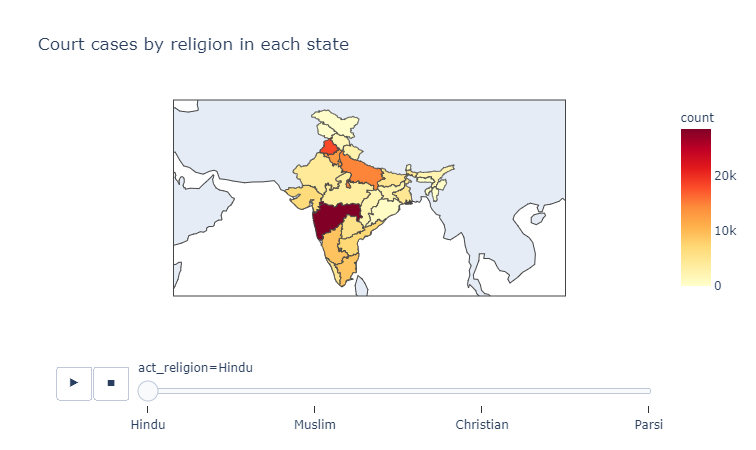

In [16]:
px.choropleth(
    freq_religions_state,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='count',
    animation_frame='act_religion',
    fitbounds="locations",
    color_continuous_scale='YlOrRd',
    title='Court cases by religion in each state'
)

# Insight #3
## Checking if there is correlation between child marriage related cases and POCSO cases

In [27]:
pattern = '.*(Child|CHILD|Children|child).*(Marriage|MARRIAGE|marriage).*'
df_child_marriage = df[df.act_s.str.match(pattern)]
df_child_marriage.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s
3406592,01-03-02-207401000112014,2014,district and sessions court,Male,Female,Missing,Male,2014-04-19,2015-07-31,2014-04-25,...,Maharashtra,argument,judgement,spl. marriage petn.,Jalgaon,DISTRICT AND SESSIONS COURT JALGAON,3983.0,733738.0,0,CHILD MARRIAGE RESTRAINT ACT
3406593,01-03-18-203017001612014,2014,criminal cases,Male,Unclear/Others,Male,Male,2014-11-17,2015-09-18,2014-11-17,...,Maharashtra,evidence,acquitted,r.c.c.,Jalgaon,CIVIL CUM CRIMINAL COURT YAWAL,3983.0,1355777.0,0,CHILD MARRIAGE RESTRAINT ACT
3406594,01-03-20-200123002682014,2014,district and additional sessions court,Male,Male,Male,Unclear/Others,2014-03-15,2016-02-18,2014-07-14,...,Maharashtra,argument,disposed-otherwise,r.c.a.,Jalgaon,"District and Additional Session Court, Bhusawal",3983.0,1370990.0,0,CHILD MARRIAGE RESTRAINT ACT
3406595,01-09-03-202702004652014,2014,civil judge,Unclear/Others,Male,Missing,Male,2014-03-27,2018-03-08,2014-03-28,...,Maharashtra,judgement,disposed-otherwise,r.c.s.,Nagpur,Civil Judge Sr.Dn Jr.Dn.Nagpur.,3983.0,1416294.0,0,CHILD MARRIAGE RESTRAINT ACT
3406598,01-13-03-202702000052014,2014,civil judge senior division,Male,Male,Missing,Male,2014-01-08,2014-12-06,2014-01-08,...,Maharashtra,order,settled,r.c.s.,Chandrapur,"Civil Judge, Senior Division, Chandrapur",3983.0,3431.0,0,CHILD MARRIAGE RESTRAINT ACT


> 

In [23]:
pattern = '.*(POCSO|pocso|posco|Pocso).*'
df_pocso = df[df.act_s.str.match(pattern)]
df_pocso.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s
5062861,13-18-03-206420052512014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Missing,2014-07-05,2018-04-22,2016-04-30,...,Uttar Pradesh,appearance,decided,sumn. trail,Budaun,Chief Judicial Magistrate,12496.0,584452.0,0,POCSO
5062871,13-18-03-206502134882014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Missing,2014-12-24,2017-07-01,2016-02-24,...,Uttar Pradesh,appearance,decided,sumy. trial,Budaun,Chief Judicial Magistrate,12496.0,584452.0,0,POCSO
5062872,13-18-03-206520086852014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Missing,2014-08-05,2017-09-17,2016-01-30,...,Uttar Pradesh,appearance,decided,sumy. trial,Budaun,Chief Judicial Magistrate,12496.0,584452.0,0,POCSO
5062873,13-18-03-206520104002014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Missing,2014-09-12,2017-06-16,2016-01-23,...,Uttar Pradesh,appearance,decided,sumy. trial,Budaun,Chief Judicial Magistrate,12496.0,584452.0,0,POCSO
5062874,13-18-03-206520134832014,2014,chief judicial magistrate,Male,Unclear/Others,Missing,Missing,2014-12-24,2017-07-01,2016-01-21,...,Uttar Pradesh,appearance,decided,sumy. trial,Budaun,Chief Judicial Magistrate,12496.0,584452.0,0,POCSO


In [23]:
def get_type(act_s : str):
    pattern_child_marriage = '.*(Child|CHILD|Children|child).*(Marriage|MARRIAGE|marriage).*'
    pattern_pocso = '.*(POCSO|pocso|posco|Pocso).*'
    
    if bool(re.search(pattern_child_marriage, act_s)):
        return "Child Marriage"
    elif bool(re.search(pattern_pocso, act_s)):
        return "POCSO"
    else:
        return "Unclear"

df2['child_crime_type'] = df.apply(lambda row : get_type(row['act_s']), axis=1)

In [24]:
df3 = df2[~(df2['act_s']=='Unclear')]
df3.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_of_decision,date_first_list,...,disp_name_s,type_name_s,district_name,court_name,act,section,criminal,act_s,act_religion,child_crime_type
3155635,01-01-04-202717000132014,2014,civil judge junior division,Female,Male,Missing,Male,2014-04-18,2015-03-10,2014-06-13,...,ex-parte,r.c.s.,Nandurbar,Civil Court J.D. and J.M.F.C.Taloda,16320.0,3706.0,0,Special Marriage Act,Unclear,Unclear
3155636,01-01-08-202716000122014,2014,civil judge junior division,Female,Male,Missing,Male,2014-02-26,2017-01-24,2014-03-27,...,reject,r.c.s.,Nandurbar,"Civil Court, J.D. and J.M.F.C., Nawapur.",16320.0,868951.0,0,Special Marriage Act,Unclear,Unclear
3155637,01-01-03-207406000022014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-01,2015-07-08,2014-11-01,...,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,46338.0,0,Special Marriage Act,Unclear,Unclear
3155638,01-01-03-207406000012014,2014,district and sessions court,Female,Male,Missing,Male,2014-10-10,2018-10-19,2014-11-03,...,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320.0,1837075.0,0,Special Marriage Act,Unclear,Unclear
3155639,01-02-01-207400000042014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-15,2015-06-08,2014-11-15,...,judgement,spl. marriage petn.,Dhule,"DISTRICT AND SESSIONS COURT, DHULE",16320.0,678480.0,0,Special Marriage Act,Unclear,Unclear


# Pre-classification section

We will try cleaning the data which includes:
- Handling null values
- Feature scaling
- Handling categorical variables

But, before we begin, we must choose our classification problem. 

A few options look interesting:
- Predicting if number of cases that will be filed on a given day in a particular court will be greater than the last day or not.
- Predicting the disposition of given case
- Predicting if the disposition is dismission of the case.

Let us start of with the easier one:
## Predicting if the disposition is dismission of the case
This is an example of **binary classification**

The first thing that is to be done is to use the `disp_name_key.csv` to replace the `disp_name` in every `case_{year}.csv` file.

### Merging case and disposition csv files

In [ ]:
df = preprocessing_case_csv(2014, True)
df_disp = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "disp_name_key.csv"))

df = df.merge(df_disp, on=['year', 'disp_name'])
df = df.drop(columns='count')
df.head(10)

In [ ]:
df.adv_def_gender.value_counts()

In [ ]:
df_acts_section = pd.read_csv(ACTS_SECTIONS_CSV, usecols=['ddl_case_id', 'act', 'criminal'])

In [ ]:
df = df.merge(df_acts_section, on=['ddl_case_id'])

In [ ]:
df.head(10)

# NEW IDEAS FOR INSIGHTS

## CASES --> (ActID, SectionID, Judge stuff, Criminal)

# NEW IDEAS FOR CLASSIFICATION

- Given (first hearing date, most recent hearing date, next hearing date,{othercorrelated stuff}) --> predict if it will reach a decision in the next hearing
- Given ({correlated stuff}) --> predict case disposition
- Check for bias in case disposition w.r.t.:
    - are people in a particular state biased against the defendant?
    - is a particular state biased against females
    - is a judge biased against a certain type of act (favours defendent)

# Classification data
## Preprocessing
- Since we are done with the exploratory data analysis, it is time to figure out a classification problem and go ahead with the predictive analysis section.
- Since, most of our data was 

# Bibliography
- https://stackoverflow.com/questions/50089903/convert-column-to-timestamp-pandas-dataframe
- https://www.geeksforgeeks.org/get-minimum-values-in-rows-or-columns-with-their-index-position-in-pandas-dataframe/
- https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
- https://www.w3schools.com/python/pandas/ref_df_min.asp#:~:text=The%20min()%20method%20returns,minimum%20value%20for%20each%20row.
- https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-by-date/
- https://www.datasciencemadesimple.com/create-frequency-table-of-column-in-pandas-python-2/
- https://datagy.io/pandas-value-counts/
- https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
- https://stackoverflow.com/questions/32888124/pandas-out-of-bounds-nanosecond-timestamp-after-offset-rollforward-plus-adding-a
-  https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
-  https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
-  https://stackoverflow.com/questions/61233041/module-not-found-error-no-module-named-chart-studio
-  https://plotly.com/python/ipython-notebook-tutorial/
- https://stackoverflow.com/questions/68149831/find-if-date-is-weekend-or-weekday-in-pandas-dataframe
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
- https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
- https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
- https://pynative.com/pandas-set-index/
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
- https://stackoverflow.com/questions/62230507/multiple-columns-for-hue-parameter-in-seaborn-violinplot
- https://seaborn.pydata.org/generated/seaborn.violinplot.html
- https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
- https://stackoverflow.com/questions/47002168/correlation-between-two-non-numeric-columns-in-a-pandas-dataframe
- https://stackoverflow.com/questions/48673428/python-pandas-pairwise-frequency-table-with-many-columns
- https://stackoverflow.com/questions/47002168/correlation-between-two-non-numeric-columns-in-a-pandas-dataframe
- https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
- 

# OFFICIAL SUBMISSION AREA END**
